<a href="https://colab.research.google.com/github/LSDtopotools/lsdtt_notebooks/blob/master/lsdtopotools/debugging_gdal_and_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debugging gdal and proj

Many geospatial applications require the use of a library called `gdal`. This verty frequently breaks with updates becasue it relies on a library called `proj` which seems to never seems to update at the same time. Almost every time colab updates gdal will stop working.

Frequently this is just because gdal doesn't know where two files are: `proj.db` and `proj.so`. So many problems can be fixed simply by pointing the system to these files.

## Install some packages

The first thing you need to do is install a few packages. We install some things for visualising topographic data first, and then we need to install something called condacolab.

In [5]:
!pip install -y lsdviztools &> /dev/null

Now condacolab. When this is done, it will restart your kernal (a message will say that your session has crashed, but that is just condacolab doing its job).

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


Now install gdal and proj (and lsdtopotools for some data processing)

In [1]:
!mamba install -y gdal proj lsdtopotools &> /dev/null

## Fixing the link to the proj database

To fix the proj database, we need to know where the proj file is, we use `find`:

In [2]:
!find / -type f -name proj.db

find: ‘/proc/60/task/60/net’: Invalid argument
find: ‘/proc/60/net’: Invalid argument
/usr/local/lib/python3.10/dist-packages/pyproj/proj_dir/share/proj/proj.db
/usr/local/lib/python3.10/dist-packages/fiona/proj_data/proj.db
/usr/local/share/proj/proj.db
/usr/local/pkgs/proj-9.2.1-ha643af7_0/share/proj/proj.db
/usr/share/proj/proj.db


So if you have proj, there are a few versions. Just pick one of them and set that directory in an environment variable using the python package `os`. You only need to change the directory path below (in my case the path is `'/usr/local/share/proj/'`.

In [7]:
import os
os.environ['PROJ_LIB'] = '/usr/local/share/proj/'
print(os.getenv('PROJ_LIB'))

/usr/local/share/proj/


## Testing using USGS data

We will test this using USGS data that I get from OpenTopography.org.
You need to download some USGS data (https://portal.opentopography.org/raster?opentopoID=OTNED.012021.4269.1)

In [12]:
!tar -xzf rasters_USGS10m.tar.gz

In [13]:
!gdalinfo output_USGS10m.tif

Driver: GTiff/GeoTIFF
Files: output_USGS10m.tif
Size is 2284, 1626
Coordinate System is:
GEOGCRS["NAD83",
    DATUM["North American Datum 1983",
        ELLIPSOID["GRS 1980",6378137,298.257222101004,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4269]]
Data axis to CRS axis mapping: 2,1
Origin = (-117.038796295600122,33.914074074220586)
Pixel Size = (0.000092592592692,-0.000092592592692)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-117.0387963,  33.9140741) (117d 2'19.67"W, 33d54'50.67"N)
Lower Left  (-117.0387963,  33.7635185) (117d 2'19.67"W, 33d45'48.67"N)
Upp

In [14]:
!gdalwarp -t_srs '+proj=utm +zone=11 +north +datum=WGS84' -of ENVI -r cubic -tr 10 10 output_USGS10m.tif my_DEM.bil

Creating output file that is 1959P x 1671L.
Processing output_USGS10m.tif [1/1] : 0Using internal nodata values (e.g. -999999) for image output_USGS10m.tif.
Copying nodata values from source output_USGS10m.tif to destination my_DEM.bil.
...10...20...30...40...50...60...70...80...90...100 - done.


In [15]:
import lsdviztools.lsdmapwrappers as lsdmw

## Get the basins
lsdtt_parameters = {"write_hillshade" : "true"}
r_prefix = "my_DEM"
w_prefix = "my_DEM"
lsdtt_drive = lsdmw.lsdtt_driver(command_line_tool = "lsdtt-basic-metrics",
                                 read_prefix = r_prefix,
                                 write_prefix= w_prefix,
                                 read_path = "./",
                                 write_path = "./",
                                 parameter_dictionary=lsdtt_parameters)
lsdtt_drive.print_parameters()
lsdtt_drive.run_lsdtt_command_line_tool()

The lsdtopotools command line tools available are: 
['lsdtt-basic-metrics', 'lsdtt-channel-extraction', 'lsdtt-chi-mapping', 'lsdtt-cosmo-tool', 'lsdtt-hillslope-channel-coupling', 'lsdtt-valley-metrics']
Testing has been done against lsdtopotools v0.7
The command line tool is: lsdtt-basic-metrics
The driver name is: Test_01
The read path is: ./
The write path is: ./
The read prefix is: my_DEM
The write prefix is: my_DEM
The parameter dictionary is:
{'write_hillshade': 'true'}
Done writing the driver file
I've finised writing the driver file. Let me run LSDTT for you.


In [16]:
%%capture
# Use the capture comment to get rid of all the text
# But it will also not display an inline image
# So you need to call the image from the next line of code
DataDirectory = "./"
Base_file = r_prefix
this_img = lsdmw.SimpleHillshade(DataDirectory,Base_file,cmap="gist_earth",
                                 save_fig=True, size_format="geomorphology",dpi=600)

./my_DEM_hillshade.png


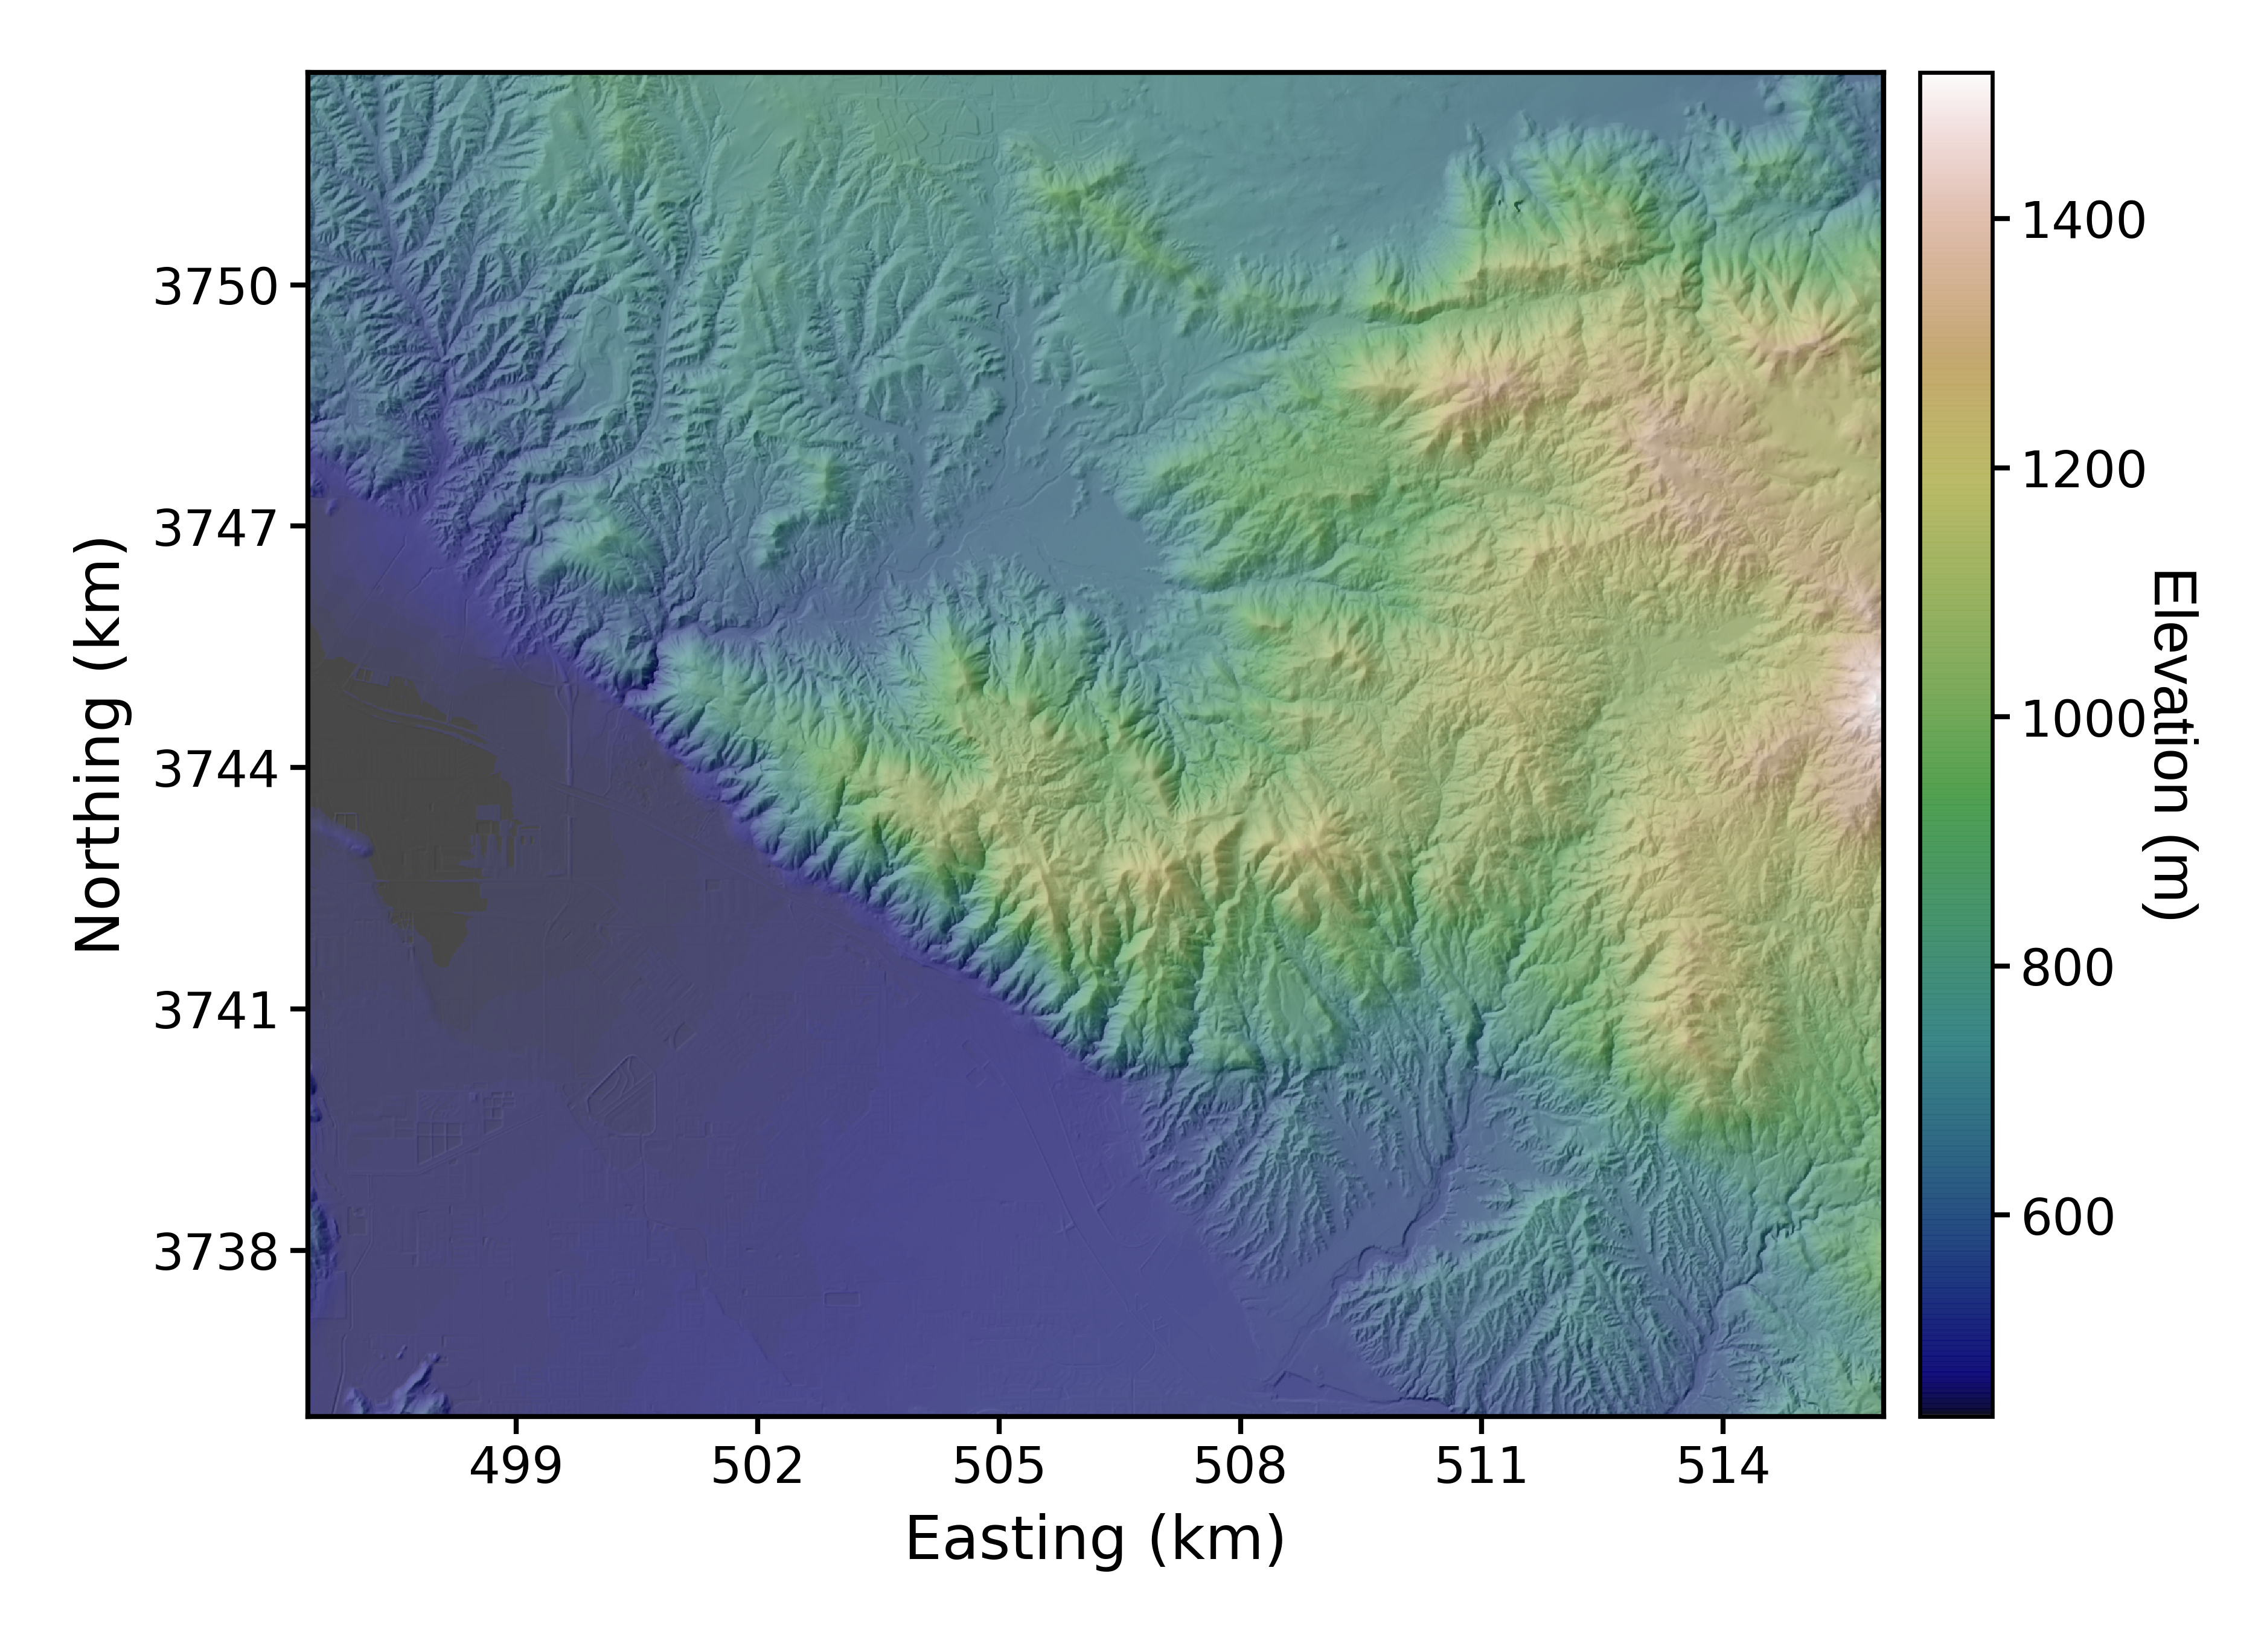

In [17]:
print(this_img)
from IPython.display import display, Image
display(Image(filename=this_img, width=800))

## Test using scottish lidar